## <center> Python implementation of Kernel Current Source Density (kCSD) method - TUTORIAL

In [1]:
%load_ext autoreload
%autoreload 2

from ipywidgets import interact
import numpy as np
import config

import plotting_helpers as plots
from widget_helpers import dim_select, csd_select, kcsd_select, accordion, nr_ele_select, nr_broken_ele

ModuleNotFoundError: No module named 'csd_profile'

In [2]:
# Select dimensions of your setup
dim_select

NameError: name 'dim_select' is not defined

In [49]:
# Select a type of CSD source
csd_select


ToggleButtons(description='True source type', options=('quadpole small', 'dipole large'), value='monopole gauss')

1. Choose dimension
2. Choose true_csd profile/function
3. Where to generate source and make reconstruction
4. Choose number of electrodes
5. Initialize Class


In [50]:
kcsd_select


ToggleButtons(description='KCSD method', options=('ValidationClassKCSD2D', 'MoIKCSD'), value='ValidationClassKCSD1D')

In [51]:
nr_ele_select

BoundedIntText(value=16, description='Select nr of electrodes:', max=200, min=1)

In [52]:
print(nr_ele_select.value)
print(dim_select.value)

16
2D


### With noise or without???

In [53]:
k = config.kCSD(config.csd_profile, 5, total_ele=nr_ele_select.value, true_csd_xlims=[0, 1],
                **config.defaults[config.kCSD.__name__])
print(config.kCSD)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [43]:
print(config.csd_profile)

<function gauss_2d_small at 0x7fca1c5bb1e0>


Number of electrodes: 13
No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 2.15443469003e-10


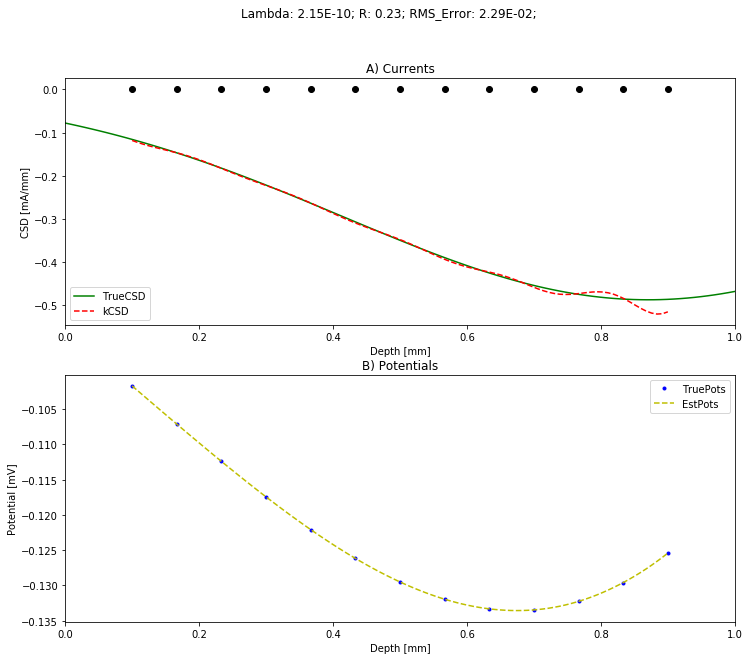

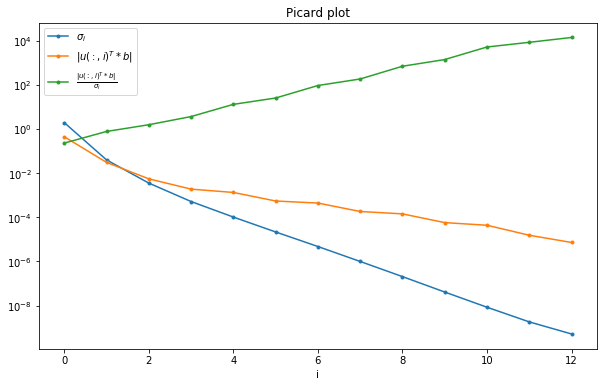

IndexError: index 12 is out of bounds for axis 0 with size 12

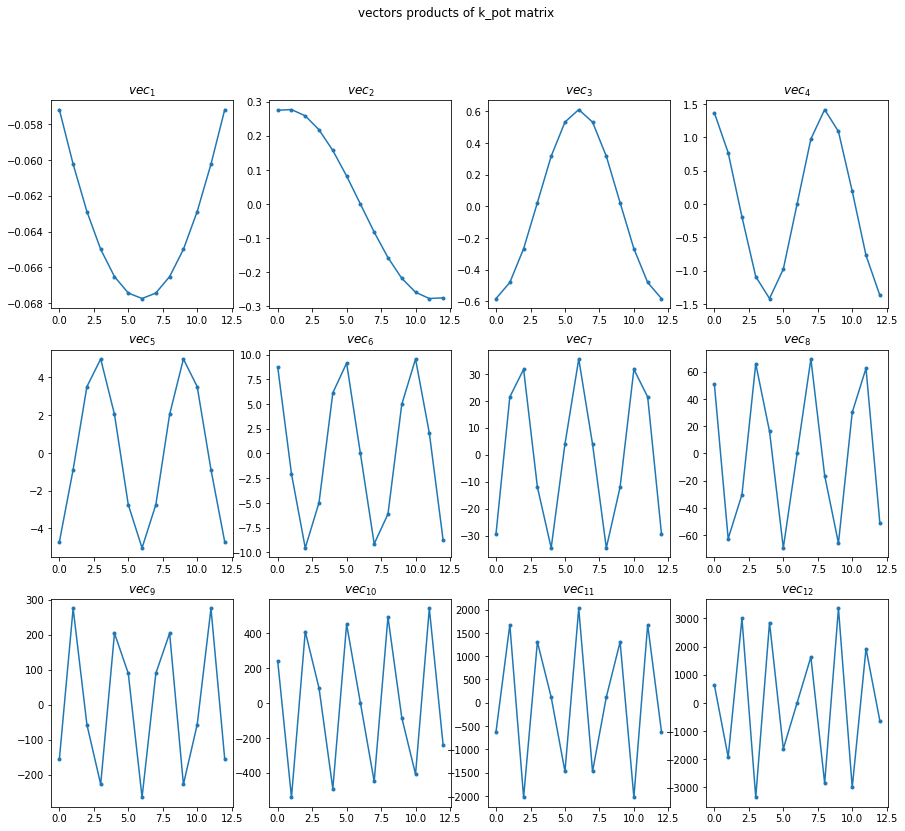

In [29]:
kcsd, rms, point_error = k.make_reconstruction(config.csd_profile)

In [24]:
# Checking spectral structure

structure = config.SpectralStructure(kcsd)

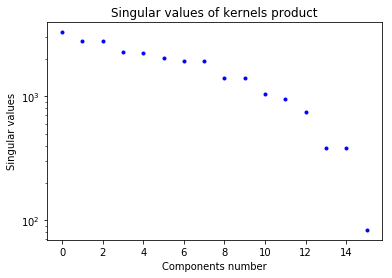

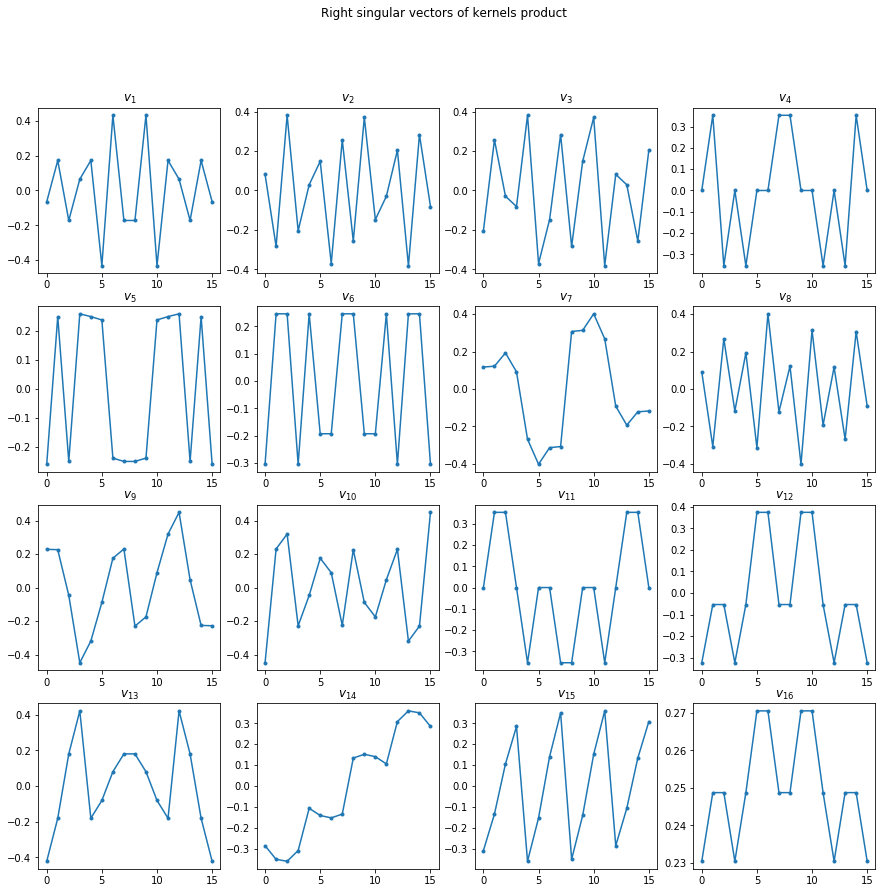

In [25]:
u_svd, sigma, v_svd = structure.svd()

Error map

how many random sources should be included?

In [10]:
print(config.error_map)

<class 'ErrorMap.ErrorMap1D'>


In [42]:
err = config.error_map(config.csd_profile, 1, total_ele=nr_ele_select.value, true_csd_xlims=[0, 1],
                 **config.defaults[config.kCSD.__name__])

regular


Broken electrodes


Button for choosing nr of broken electrodes

In [41]:
rms, point_error = err.calculate_error_map(config.csd_profile)

Number of electrodes: 27
No lambda given, using defaults
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
R, lambda : 0.1 0.00110069417125
Number of electrodes: 27
No lambda given, using defaults
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
R, lambda : 0.1 4.64158883361e-18
Number of electrodes: 27
No lambda given, using defaults
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
R, lambda : 0.1 4.21696503429e-17
Number of electrodes: 27
No lambda given, using defaults
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
R, lambda : 0.2 0.01
Number of electrodes: 27
No lambda given, 

#### Calculate errors for Error Map

It may take a few minutes.

Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 1.61559809844e-07
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 1.77827941004e-08
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.4 3.83118684956e-16
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.64158883361e-18
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda

Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.4 1.33352143216e-05
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.3 0.000121152765863
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.3 1.33352143216e-05
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.3 1.46779926762e-06
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda

Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 1.77827941004e-08
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.4 4.64158883361e-18
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 5.10896977451e-19
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 1.33352143216e-05
Number of electrodes: 25
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda

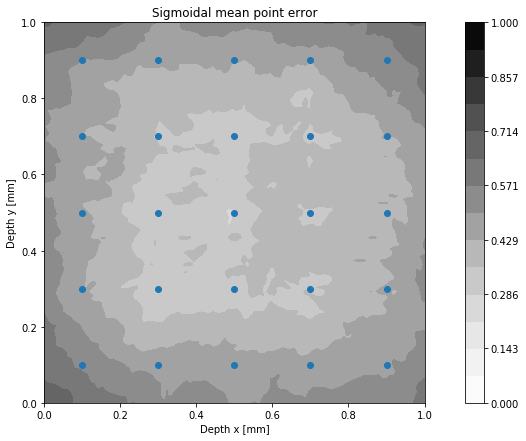

In [43]:
rms, point_error = err.calculate_error_map(config.csd_profile)

In [63]:
print(point_error.shape)

(100, 100, 100)


In [49]:
ele_pos, pots = k.electrode_config(config.csd_profile)
print(ele_pos.shape)

Number of electrodes: 25
(25, 2)


In [59]:
def plot_mean_error(point_error, ele_pos):
        """
        Creates plot of mean error calculated separately for every point of
        estimation space

        Parameters
        ----------
        point_error: numpy array

        Returns
        -------
        None
        """
        ele_x = ele_pos[:, 0]
        ele_y = ele_pos[:, 1]
        x, y = np.mgrid[0:1:
                        np.complex(0, 100),
                        0:1:
                        np.complex(0, 100)]
        mean_error = err.sigmoid_mean(point_error)
        print(mean_error.shape)
        plt.figure(figsize=(12, 7))
        ax1 = plt.subplot(111, aspect='equal')
        levels = np.linspace(0, 1., 15)
        im = ax1.contourf(x, y, mean_error, levels=levels, cmap='Greys')
        plt.colorbar(im, fraction=0.046, pad=0.06)
        plt.scatter(ele_x, ele_y)
        ax1.set_xlabel('Depth x [mm]')
        ax1.set_ylabel('Depth y [mm]')
        ax1.set_title('Sigmoidal mean point error')
        plt.show()
        return

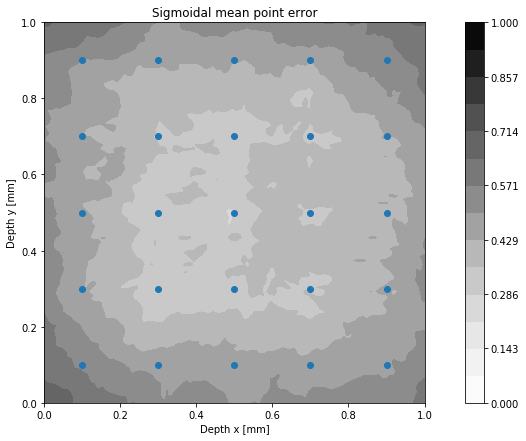

In [55]:
plot_error_map(point_error, ele_pos)

plot results for 3D reconstruction and error maps for different layers (with slider)


use 2 subplots (left - reconstruction, right - error map for the same layer) - change it simultanously

In [1]:
# plot results for 3D reconstruction and error maps for different layers (with slider)

# use 2 subplots (left - reconstruction, right - error map for the same layer) - change it simultanously

import plotly.plotly as py

In [16]:
nr_broken_ele

BoundedIntText(value=5, description='Select number of broken electrodes:', max=9, min=1)

In [13]:
print(nr_broken_ele.value)

2


In [46]:
err_broken = config.error_map(config.csd_profile, 1, total_ele=nr_ele_select.value, true_csd_xlims=[0, 1],
                              **config.defaults[config.kCSD.__name__], ele_config='broken')

broken


In [62]:
print(config.csd_profile)

<function gauss_2d_small at 0x7f8055cf9e18>


In [47]:
rms_br, point_error_br = err_broken.calculate_error_map(config.csd_profile, nr_broken_ele=nr_broken_ele.value)

Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.21696503429e-17
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 3.83118684956e-16
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.64158883361e-18
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.4 1.46779926762e-06
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda

No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.3 1.33352143216e-05
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.3 0.000121152765863
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.3 0.00110069417125
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.3 4.64158883361e-18
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.21696503429e-17
N

No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 1.61559809844e-07
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.3 0.000121152765863
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 1.61559809844e-07
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.4 0.000121152765863
Number of electrodes: 19
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.3 0.01
Number of ele

AttributeError: 'ErrorMap2D' object has no attribute 'broken_electrode'

In [64]:
print(rms.shape)

(100,)


In [56]:
ele_pos, pots = err_broken.electrode_config(config.csd_profile, nr_broken_ele=nr_broken_ele.value)
print(pots.shape)

Number of electrodes: 19
(19, 1)


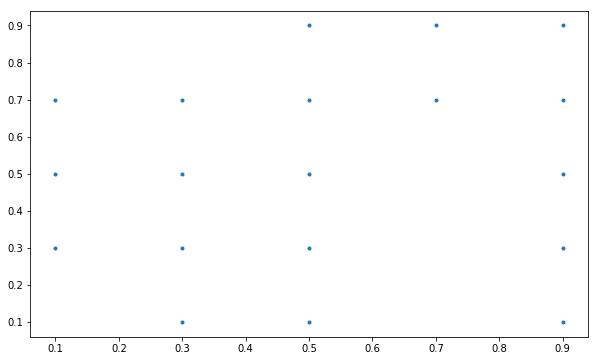

In [67]:
plt.plot(ele_pos[:, 0], ele_pos[:, 1], '.')

In [ ]:
plot_error_map(point_error_br, ele_pos)

In [32]:
err_broken2 = config.error_map(config.csd_profile, 1, total_ele=nr_ele_select.value, true_csd_xlims=[0, 1],
                              **config.defaults[config.kCSD.__name__], ele_config='broken')

broken


In [33]:
rms_br2, point_error_br2 = err_broken2.calculate_error_map(config.csd_profile, nr_broken_ele=nr_broken_ele.value)

hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.64158883361e-18
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.64158883361e-18
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.21696503429e-17
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 1.46779926762e-06
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross valida

Cross validating R (all lambda) : 0.5
R, lambda : 0.5 3.83118684956e-16
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.21696503429e-17
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.21696503429e-17
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.64158883361e-18
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.64158883361e-18
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating

Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.21696503429e-17
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.21696503429e-17
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.21696503429e-17
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 1.33352143216e-05
hi
here
Number of electrodes: 3
No lambda given, using defaults
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.5
R, lambda : 0.5 4.21696503429e-17
hi
here
Number of electrodes: 3
No lambda 

In [34]:
ele_pos, pots = err_broken.electrode_config(config.csd_profile, nr_broken_ele=nr_broken_ele.value)
print(pots.shape)

hi
here
Number of electrodes: 3
(3, 1)


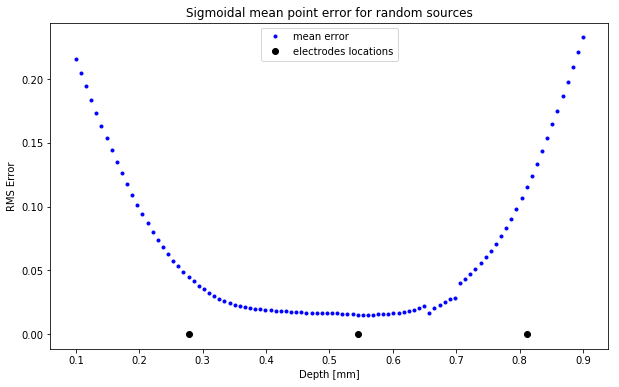

In [35]:
err_broken2.plot_error_map(point_error_br2, ele_pos)

In [28]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


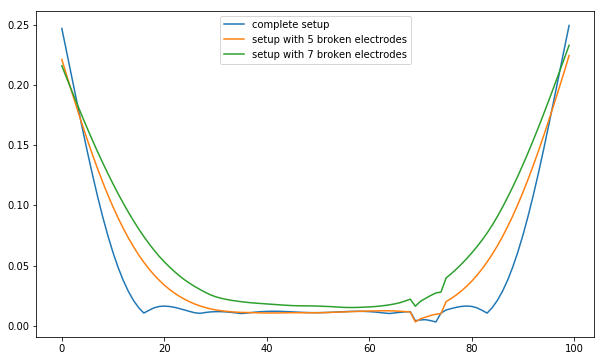

In [36]:
m_error = err_broken.sigmoid_mean(point_error)
m_error_br = err_broken.sigmoid_mean(point_error_br)
m_error_br2 = err_broken2.sigmoid_mean(point_error_br2)
plt.figure()
plt.plot(m_error, label='complete setup')
plt.plot(m_error_br, label='setup with 5 broken electrodes')
plt.plot(m_error_br2, label='setup with 7 broken electrodes')
plt.legend()